# Image Reconstruction

This notebook is the Python implementation of the Image Reconstruction exercise.

You can download example corrupted images and corruption masks from our course's Moodle page. Alternatively, you may generate them from custom images using the "Image_Corruption" notebook, which can also be found on Moodle.

There are a few remarks regarding this notebook that you should keep in mind.

* Only PNG images are supported.
* Large images need a lot of time to be processed.
* Grayscale images behave differently from color images, as they only save one value per pixel instead of three.
* We encourage you to implement your own function for calculating the $\ell_{2}$ variation, but you may also use the one provided by CVXPY.

In [11]:
import matplotlib.pyplot as plt  # for plotting in Python
import numpy as np  # for number manipulation
import cvxpy as cp  # for solving convex programs

In [12]:
# Displays two images side-by side
def display_two_images(left_image, right_image, left_image_title='Original Image', right_image_title='Corrupted Image'):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(left_image, cmap='gray')
    ax[0].set_title(left_image_title)
    ax[0].axis('off')
    ax[1].imshow(right_image, cmap='gray')
    ax[1].set_title(right_image_title)
    ax[1].axis('off')

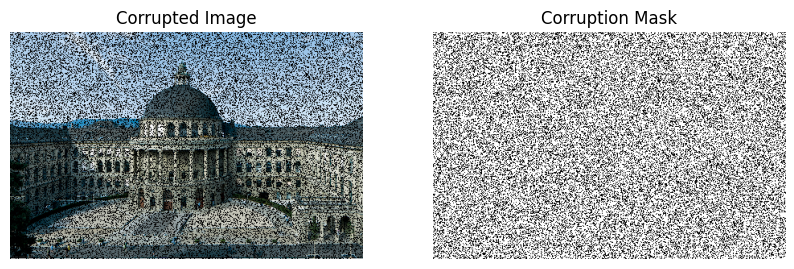

In [13]:
# Load corrupted image and corruption mask
corrupted = plt.imread('eth_noise.png')
mask = plt.imread('eth_noise_mask.png')
rows, cols = corrupted.shape[:2]

# Display corrupted image and corruption mask
display_two_images(corrupted, mask, 'Corrupted Image', 'Corruption Mask')

Model the image reconstruction problem as a convex program and solve it using CVXPY here.

In [14]:
if len(corrupted.shape)==2:
    print(corrupted.shape)
    print(mask.shape)

    D = cp.Variable(corrupted.shape)
    lowerbound = np.zeros_like(D)
    upperbound = np.ones_like(D)

    """"
    squared_distance = 0
    for i in range(corrupted.shape[0]-1):
        for j in range(corrupted.shape[1]-1):
            if mask[i,j] == 0:
                squared_distance += cp.norm(cp.vstack([D[i+1, j] - D[i, j], D[i, j+1] - D[i, j]]), 2)
    """
    # Compute the horizontal and vertical differences
    Dx = D[1:, :-1] - D[:-1, :-1]  # Difference along rows
    Dy = D[:-1, 1:] - D[:-1, :-1]  # Difference along columns

    # Apply the mask to only consider valid pixels
    masked_Dx = cp.multiply(1-mask[:-1, :-1], Dx)
    masked_Dy = cp.multiply(1-mask[:-1, :-1], Dy)

    # Compute squared Euclidean norm sum
    squared_distance = cp.sum(cp.norm(cp.hstack([masked_Dx, masked_Dy]), 2, axis=1))

    constraints = [D<=upperbound,
                D>=lowerbound,
                D[mask==1] == corrupted[mask==1]]
    objective = cp.Minimize(squared_distance)
    problem = cp.Problem(objective, constraints)

    # Risolvere il problema
    problem.solve()

    #print("Optimal D:", D.value)
    reconstruction = D.value  # Ensure same shape as the corrupted image

    #print(reconstruction.shape, type(reconstruction))


In [15]:
import cvxpy as cp
import numpy as np

# Example corrupted image and mask (Ensure these exist before running)
# corrupted = np.random.rand(283, 439, 3)  # Simulated RGB image
# mask = np.random.randint(0, 2, (283, 439))  # Binary mask

if len(corrupted.shape) == 3:  # Ensure image is RGB
    print("Corrupted shape:", corrupted.shape)
    print("Mask shape before expansion:", mask.shape)

    # Expand mask to match RGB dimensions
    mask = np.repeat(mask[:, :, np.newaxis], 3, axis=-1)  # Shape: (283, 439, 3)
    print("Mask shape after expansion:", mask.shape)  # Output: (283, 439, 3)

    # Define CVXPY variable
    D = cp.Variable(corrupted.shape)

    # Define upper and lower bounds (0 to 1 for pixel intensity)
    lowerbound = 0
    upperbound = 1

    # Compute finite differences for smoothness (per channel)
    Dx = D[1:, :, :] - D[:-1, :, :]  # Vertical difference
    Dy = D[:, 1:, :] - D[:, :-1, :]  # Horizontal difference

    # Apply the mask to keep only pixels where mask == 0
    masked_Dx = cp.multiply(1 - mask[:-1, :, :], Dx)
    masked_Dy = cp.multiply(1 - mask[:, :-1, :], Dy)

    # Compute squared Euclidean norm sum correctly (per channel)
    squared_distance = cp.sum(cp.square(Dx)) + cp.sum(cp.square(Dy))

    # Define constraints (fix known pixels correctly)
    constraints = [
        D <= upperbound,  # Ensure pixels stay in range [0, 1]
        D >= lowerbound,
        cp.multiply(mask, D) == cp.multiply(mask, corrupted)  # Ensure known pixels remain fixed
    ]

    # Define optimization problem
    objective = cp.Minimize(squared_distance)
    problem = cp.Problem(objective, constraints)

    # Solve the problem
    problem.solve()

    # Retrieve the reconstructed image
    reconstruction = D.value

    print("Reconstruction shape:", reconstruction.shape, type(reconstruction))


Corrupted shape: (283, 439, 3)
Mask shape before expansion: (283, 439)
Mask shape after expansion: (283, 439, 3)
Reconstruction shape: (283, 439, 3) <class 'numpy.ndarray'>


The corrupted and the reconstructed image can be compared side by side.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.538555666722438e-14..1.0000000000000049].


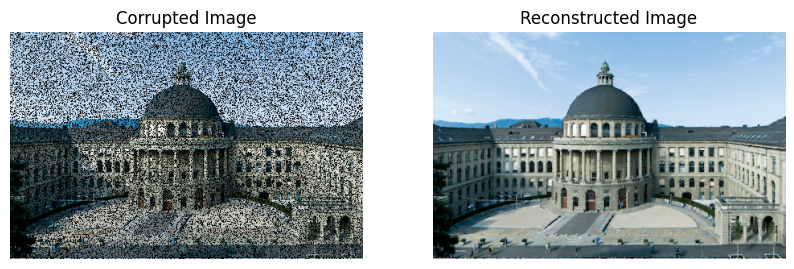

In [16]:
# Display corrupted and reconstructed image for comparison
display_two_images(corrupted, reconstruction, 'Corrupted Image', 'Reconstructed Image')

The reconstructed image can also be compared to the original one (provided it is accessible).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.538555666722438e-14..1.0000000000000049].


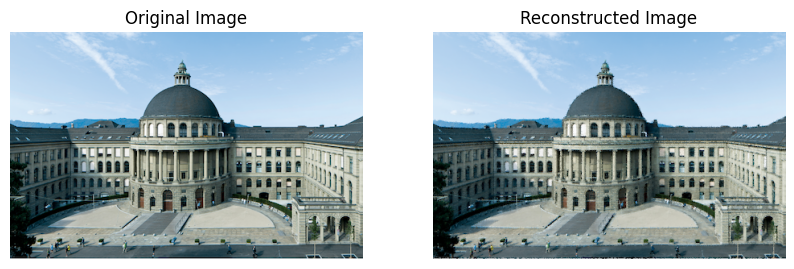

In [17]:
# Display original image and reconstruction for comparison
original = plt.imread('eth.png')
display_two_images(original, reconstruction, 'Original Image', 'Reconstructed Image')